In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from task_decomposition.analysis.comparisons import (get_subtask_similarity,
                                                     get_IOU,
                                                     get_semantic_distance,
                                                     extract_subtask_from_groundtruth_file,
                                                     extract_subtask_from_LLM_output_file)
from task_decomposition.utils.random_subtask_decomposition import get_random_subtask_decomposition
from task_decomposition.paths import (ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH, 
                                      LLM_OUTPUT_PATH,
                                      SAVE_PLOTS_PATH,
                                      BASELINES_DATA)
from task_decomposition.constants import (START_STEP_IDX, 
                                          END_STEP_IDX, 
                                          DESCRIPTION_IDX, 
                                          ENVIRONMENT_NAMES)

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-14 21:18:33.489868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Paper example calcs

In [2]:
A = (40, 48, 'Align Cube A with Cube B')
B = (40, 54, 'robot arm lifting cube A')
K_s3, K_s4 = 62, 62
_MAX_LENGTH = max(K_s3, K_s4)
_IOU = get_IOU(A, B)
_SD = get_semantic_distance(A[DESCRIPTION_IDX], B[DESCRIPTION_IDX])
_INTERVAL_WEIGHT = (
                    min(A[END_STEP_IDX], B[END_STEP_IDX])
                    - max(A[START_STEP_IDX], B[START_STEP_IDX])
                    + 1
                ) / _MAX_LENGTH
print(f'IOU: {_IOU}, SD: {_SD}, Interval Weight: {_INTERVAL_WEIGHT}')

IOU: 0.5714285714285714, SD: 0.5042115449905396, Interval Weight: 0.14516129032258066


### Helper Functions

In [2]:
def _get_filepaths(env_name: str, 
                   llm_model: str, 
                   input_mode: str,  
                   kind:str, 
                   in_context: bool) -> list:
    """
    Get the list of groundtruth or LLM output filepaths for a given environment
    """
    if kind == "groundtruth":
        files_path = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)
    elif kind == "llm_output":
        files_path = LLM_OUTPUT_PATH(llm_model=llm_model, 
                                     input_mode=input_mode, 
                                     env_name=env_name,
                                     in_context=in_context)
    else:
        raise ValueError(f"Invalid kind {kind}. Must be either 'groundtruth' or 'llm_outputs'.")
    files = os.listdir(files_path)
    files.remove(".gitkeep") if ".gitkeep" in files else None
    files.remove(".DS_Store") if ".DS_Store" in files else None
    files = [os.path.join(files_path, file) for file in files]
    files = sorted(files)
    return files

### Trajectory Visualization Functions

In [118]:
def format_string(s: list) -> str:
    """
    Add a newline after every 3 words in the list
    """
    N_WORDS_PER_LINE = 2
    x = s.split(" ")
    s_format = []
    for i in range(len(x)):
        s_format.append(x[i])
        s_format.append("\n") if i % N_WORDS_PER_LINE == 0 else None
    return " ".join(s_format)

# Redefine the add_intervals_with_colors function to position the text at the edges
def add_intervals_with_colors(intervals, row, color, ax, angle):
    for idx, (start, end, description) in enumerate(intervals):
        rect_width = end - start if end - start > 0 else 1
        rect = mpatches.Rectangle(
            (start, row), rect_width, 0.8, edgecolor="black", facecolor=color
        )
        ax.add_patch(rect)

        # Position the text at the top and bottom edges of the bars
        if row == 10:  # For the top bar, start the text at the top edge
            text_y = row + 0.8
            va = "bottom"
        else:  # For the bottom bar, start the text at the bottom edge
            text_y = row - 0.8
            va = "top"

        # Place the text at a 45 degree angle for actual and -45 for predicted
        ax.text(
            (start+end) / 2,
            text_y,
            format_string(description),
            ha="left",
            va=va,
            fontsize="large",
            color="black",
            rotation=angle,
            rotation_mode="anchor",
        )

def plot_compare_two_trajectories(actual, 
                                  predicted, 
                                  subtask_decomp_names, 
                                  title=False, 
                                  save=False,
                                  filename=None,
                                  ax=None):
    # Add actual intervals with color map and angle the text at 45 degrees
    add_intervals_with_colors(actual, 1, 'green', ax, angle=35)

    # Add predicted intervals with color map and angle the text at -45 degrees
    add_intervals_with_colors(predicted, 0, 'blue', ax, angle=-35)

    # Set the limits, labels, and title
    ax.set_xlim(-1, max(actual[-1][END_STEP_IDX], predicted[-1][END_STEP_IDX])+5)
    ax.set_ylim(-3, 6)
    ax.set_yticks([0.4, 1.4])
    ax.set_yticklabels([subtask_decomp_names[1], 
    subtask_decomp_names[0]], fontsize=12)
    ax.set_xlabel("Step Number")
    ax.set_title(title, fontsize=14) if title else None
    ax.spines['top'].set_visible(False) # This removes the top boundary
    ax.spines['bottom'].set_visible(False) # This removes the bottom boundary
    ax.spines['left'].set_visible(False) # This removes the top boundary
    ax.spines['right'].set_visible(False) # This removes the bottom boundary

    # save plot as svg file
    if save:
        plt.savefig(f"{SAVE_PLOTS_PATH}/{filename}.svg", format="svg")
        plt.savefig(f"{SAVE_PLOTS_PATH}/{filename}.png", format="png")

    plt.tight_layout()
    plt.show()

def plot_single_trajectory(subtask_decomp, title, color, ax=None):
    # Add actual intervals with color map and angle the text at 45 degrees
    add_intervals_with_colors(subtask_decomp, 1, color, ax, angle=35)

    # Set the limits, labels, and title
    ax.set_xlim(-1, subtask_decomp[-1][END_STEP_IDX]+5)
    ax.set_ylim(-7, 5)
    # ax.set_yticks([0.4, 1.4])
    # ax.set_yticklabels("Subtask Decomposition", fontsize=12)
    ax.set_xlabel("Step Number")
    ax.set_title(title, fontsize=14)
    ax.spines['top'].set_visible(False) # This removes the top boundary
    ax.spines['bottom'].set_visible(False) # This removes the bottom boundary

    plt.tight_layout()
    plt.show()

In [129]:
def plot_compare_4_subtask_decomposition(subtask_decomp_1, 
                                        subtask_decomp_2, 
                                        subtask_decomp_3,
                                        subtask_decomp_4, 
                                        subtask_decomp_names,
                                        title=False, 
                                        save=False,
                                        filename=None,
                                        ax=None):

    add_intervals_with_colors(subtask_decomp_1, 12, 'green', ax, angle=35)
    add_intervals_with_colors(subtask_decomp_2, 10, 'blue', ax, angle=-35)
    add_intervals_with_colors(subtask_decomp_3, 5, 'red', ax, angle=-35)
    add_intervals_with_colors(subtask_decomp_4, 0, 'gray', ax, angle=-35)

    # Set the limits, labels, and title
    ax.set_xlim(-1, max(subtask_decomp_1[-1][END_STEP_IDX], subtask_decomp_2[-1][END_STEP_IDX])+5)
    ax.set_ylim(-3, 15)
    ax.set_yticks([0.4, 1.4])
    # ax.set_yticklabels([subtask_decomp_names[2],
    #                     subtask_decomp_names[1], 
    #                     subtask_decomp_names[0]], 
    #                     fontsize=12)
    ax.set_xlabel("Step Number")
    # ax.set_title(title, fontsize=14) if title else None
    ax.spines['top'].set_visible(False) # This removes the top boundary
    ax.spines['bottom'].set_visible(False) # This removes the bottom boundary
    ax.spines['left'].set_visible(False) # This removes the top boundary
    ax.spines['right'].set_visible(False) # This removes the bottom boundary

    # save plot as svg file
    if save:
        plt.savefig(f"{SAVE_PLOTS_PATH}/{filename}.svg", format="svg")
        plt.savefig(f"{SAVE_PLOTS_PATH}/{filename}.png", format="png")

    plt.tight_layout()
    plt.show()

### Visualize Single Trajectory

[(0, 10, 'Move to above Cube A'), (11, 23, 'Move directly down to Cube A'), (24, 25, 'Grasp Cube A'), (26, 39, 'Vertically pick up Cube A'), (40, 48, 'Align Cube A with Cube B'), (49, 54, 'Move Cube A vertically down to Cube B'), (55, 58, 'Release Cube A onto Cube B'), (59, 62, 'Return Home')]


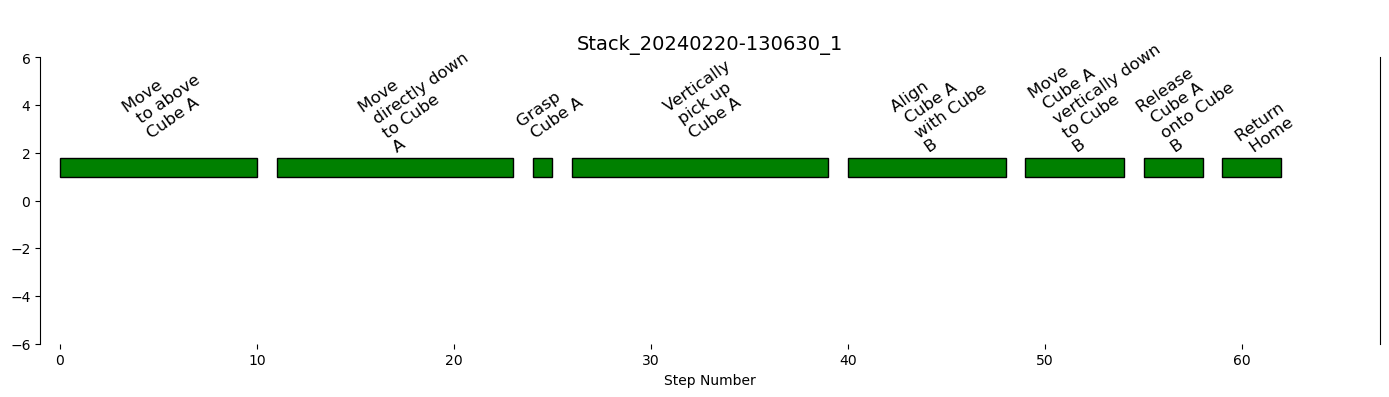

In [74]:
runid = "Stack_20240220-130630_1"
subtask_decomp = extract_subtask_from_groundtruth_file(filepath=ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH("Stack")+f"/{runid}_gt.txt")
print(subtask_decomp)
fig, ax = plt.subplots(figsize=(14, 4))
plot_single_trajectory(subtask_decomp=subtask_decomp, 
                       title=f"{runid}",
                       color="green",
                       ax=ax)

### Compare two Trajectories

Ground Truth Subtasks: [(0, 10, 'Move to above Cube A'), (11, 23, 'Move directly down to Cube A'), (24, 25, 'Grasp Cube A'), (26, 39, 'Vertically pick up Cube A'), (40, 48, 'Align Cube A with Cube B'), (49, 54, 'Move Cube A vertically down to Cube B'), (55, 58, 'Release Cube A onto Cube B'), (59, 62, 'Return Home')]
LLM Subtasks: [(0, 10, 'Move to above Cube A'), (11, 23, 'Move directly down to Cube A'), (24, 25, 'Grasp Cube A'), (26, 39, 'Vertically pick up Cube A'), (40, 54, 'Align Cube A with Cube B'), (55, 58, 'Release Cube A onto Cube B'), (59, 62, 'Return Home')]
Similarity between GT and LLM: {'temporal': 0.8775510204081632, 'semantic': 0.9836324510120209, 'total': 0.9305917357100921}


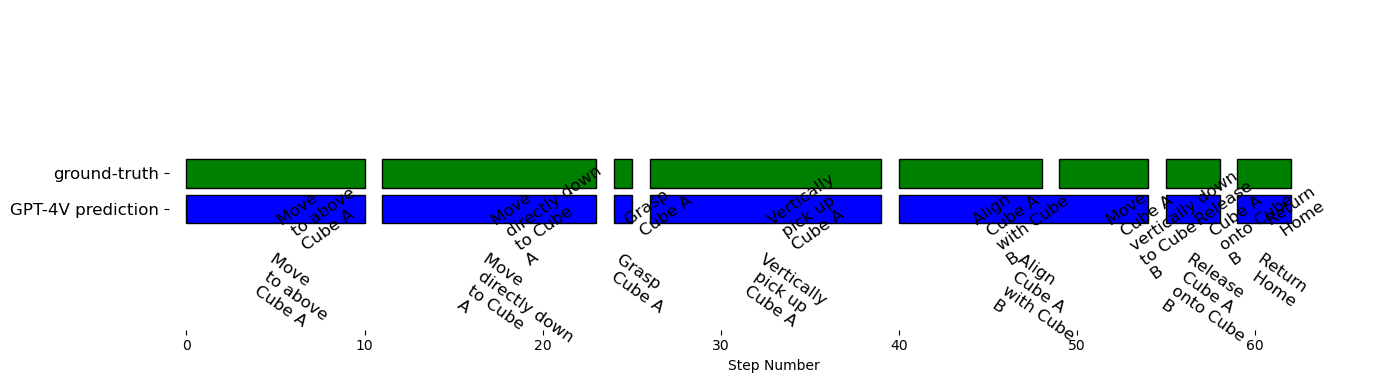

LLM Subtasks2: [(0, 10, 'robot arm moving towards cube A'), (11, 24, 'robot arm adjusting position above cube A'), (25, 39, 'robot arm descending towards cube A'), (40, 54, 'robot arm lifting cube A'), (55, 62, 'robot arm moving cube A towards cube B')]
Similarity between GT and LLM2: {'temporal': 0.7414965986394559, 'semantic': 0.5065105486483802, 'total': 0.624003573643918}


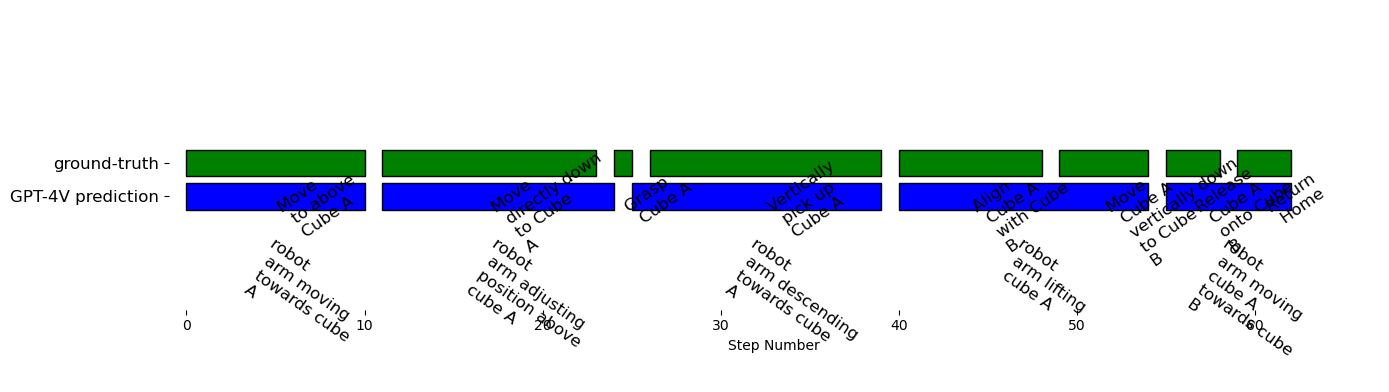

In [132]:
## visualize individual trajectory decompositions
# Example 1
llm_model = "gpt-4-vision-preview"
input_mode = "textual"
env_name = "Stack"
runid = "Stack_20240220-130630_1"
# runid = "Stack_20240220-130726_8"

# Example 2
# llm_model = "gpt-4-vision-preview"
# input_mode = "textual"
# env_name = "Lift"
# runid = "Lift_20240220-124626_1"

# Example 3
# llm_model = "video-llava"
# input_mode = "video"
# env_name = "Stack"
# runid = "Stack_20240220-131112_39"

# Example 4
# llm_model = "gemini-pro-vision"
# input_mode = "video"
# env_name = "Door"
# runid = "Door_20240213-184004_2"

## Extract the groundtruth and LLM output files
## IN CONTEXT
in_context = True
gt_file = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)+f"/{runid}_gt.txt"
llm_file = LLM_OUTPUT_PATH(llm_model=llm_model, 
                           input_mode=input_mode, 
                           env_name=env_name, 
                           in_context=True)+f"/{runid}.json" 
gt_subtasks = extract_subtask_from_groundtruth_file(filepath=gt_file)
llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file,
                                                    llm_model=llm_model)
print(f"Ground Truth Subtasks: {gt_subtasks}")
print(f"LLM Subtasks: {llm_subtasks}")
similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
print(f"Similarity between GT and LLM: {similarity}")

fig, ax = plt.subplots(figsize=(14, 4))
# title = f"Temporal Similarity: {100*similarity['temporal']:.2f}%, Semantic Similarity: {100*similarity['semantic']:.2f}%"
plot_compare_two_trajectories(actual=gt_subtasks,
                              predicted=llm_subtasks, 
                              subtask_decomp_names=["ground-truth", "GPT-4V prediction"], 
                              save=True,
                              filename=f"{runid}_llm_{llm_model}_{input_mode}_{in_context}_incontext",
                              ax=ax)

## WITHOUT INCONTEXT
in_context = False
llm_file2 = LLM_OUTPUT_PATH(llm_model=llm_model, 
                           input_mode=input_mode, 
                           env_name=env_name, 
                           in_context=in_context)+f"/{runid}.json" 
llm_subtasks2 = extract_subtask_from_LLM_output_file(filepath=llm_file2,
                                                    llm_model=llm_model)
print(f"LLM Subtasks2: {llm_subtasks2}")
similarity2 = get_subtask_similarity(gt_subtasks, llm_subtasks2)
print(f"Similarity between GT and LLM2: {similarity2}")
fig, ax = plt.subplots(figsize=(14, 4))
# title = f"Temporal Similarity: {100*similarity['temporal']:.2f}%, Semantic Similarity: {100*similarity['semantic']:.2f}%"
plot_compare_two_trajectories(actual=gt_subtasks,
                              predicted=llm_subtasks2, 
                              subtask_decomp_names=["ground-truth", "GPT-4V prediction"], 
                              save=True,
                              filename=f"{runid}_llm_{llm_model}_{input_mode}_{in_context}_incontext",
                              ax=ax)

Random Decomposition: [(0, 38, 'Sort objects by color'), (39, 42, 'Turn on a light'), (43, 49, 'Serve a meal'), (50, 53, 'Remove object from wall'), (54, 61, 'Place object on a shelf'), (62, 62, 'Sort objects by color')]
Similarity between GT and Random: {'temporal': 0.316141544337033, 'semantic': 0.14448748670873185, 'total': 0.23031451552288243}


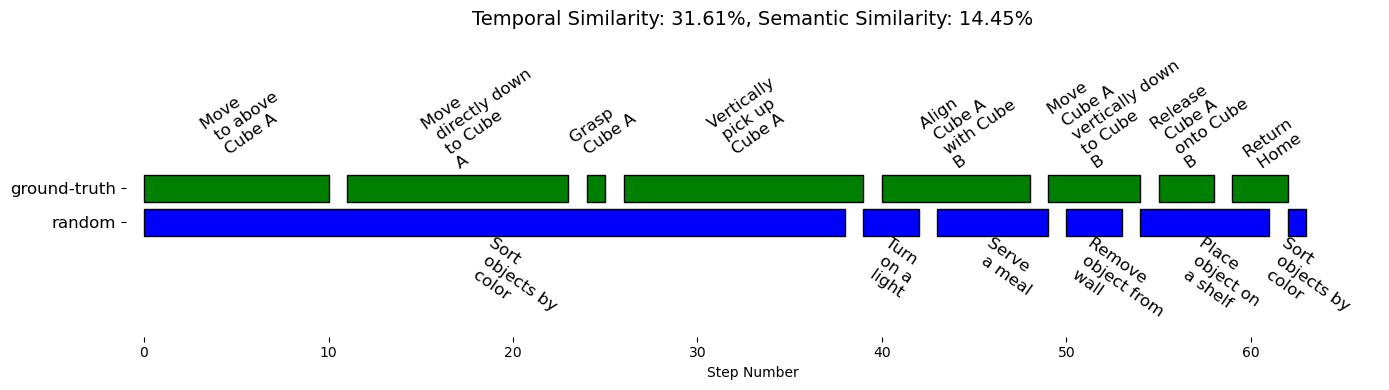

In [89]:
# random_subtask_decomposition = get_random_subtask_decomposition(gt_subtasks[-1][END_STEP_IDX])
random_subtask_decomposition = [(0, 38, 'Sort objects by color'),
                                (39, 42, 'Turn on a light'), 
                                (43, 49, 'Serve a meal'), 
                                (50, 53, 'Remove object from wall'), 
                                (54, 61, 'Place object on a shelf'), 
                                (62, 62, 'Sort objects by color')]
print(f"Random Decomposition: {random_subtask_decomposition}")
similarity = get_subtask_similarity(gt_subtasks, random_subtask_decomposition)
print(f"Similarity between GT and Random: {similarity}")
fig, ax = plt.subplots(figsize=(14, 4))
title = f"Temporal Similarity: {100*similarity['temporal']:.2f}%, Semantic Similarity: {100*similarity['semantic']:.2f}%"
plot_compare_two_trajectories(actual=gt_subtasks,
                              predicted=random_subtask_decomposition, 
                              title=title,
                              subtask_decomp_names=["ground-truth", "random"], 
                              save=True,
                              filename=f"{runid}_random_{input_mode}",
                              ax=ax)
# 
# Random Decomposition: [(0, 38, 'Sort objects by color'), (39, 42, 'Turn on a light'), (43, 49, 'Serve a meal'), (50, 53, 'Remove object from wall'), (54, 61, 'Turn on a light'), (62, 62, 'Sort objects by color')]

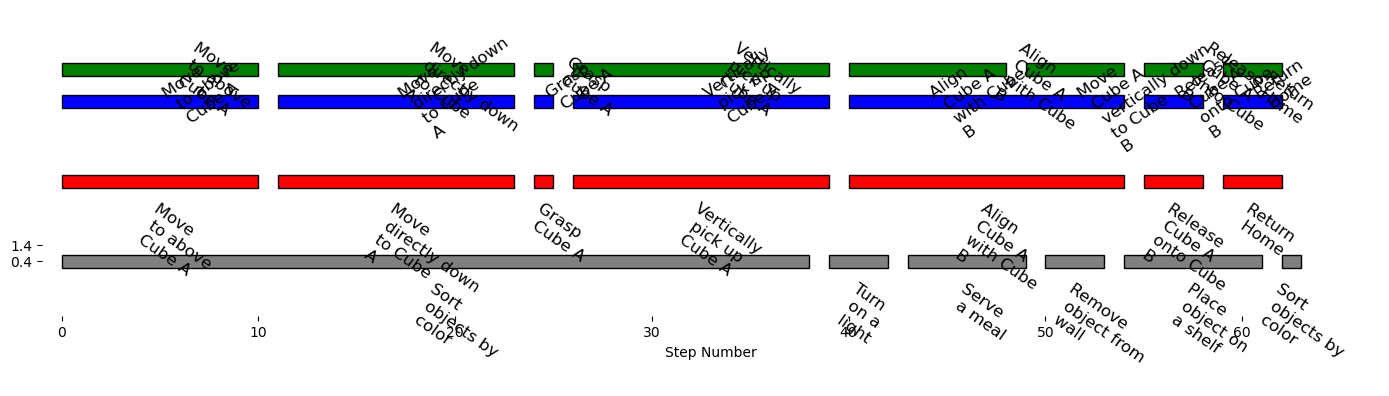

In [130]:
## Extract the groundtruth and LLM output files
## IN CONTEXT
llm_model = "gpt-4-vision-preview"
input_mode = "textual"
env_name = "Stack"
runid = "Stack_20240220-130630_1"
gt_file = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)+f"/{runid}_gt.txt"
gt_subtask_decomp = extract_subtask_from_groundtruth_file(filepath=gt_file)

llm_file_1S = LLM_OUTPUT_PATH(llm_model=llm_model, 
                           input_mode=input_mode, 
                           env_name=env_name, 
                           in_context=True)+f"/{runid}.json" 
subtask_decomp_1S = extract_subtask_from_LLM_output_file(llm_model=llm_model,
                                                         filepath=llm_file_1S)

llm_file_0S = LLM_OUTPUT_PATH(llm_model=llm_model, 
                           input_mode=input_mode, 
                           env_name=env_name, 
                           in_context=True)+f"/{runid}.json" 
subtask_decomp_0S = extract_subtask_from_LLM_output_file(llm_model=llm_model,
                                                         filepath=llm_file_0S)

random_subtask_decomposition = [(0, 38, 'Sort objects by color'),
                                (39, 42, 'Turn on a light'), 
                                (43, 49, 'Serve a meal'), 
                                (50, 53, 'Remove object from wall'), 
                                (54, 61, 'Place object on a shelf'), 
                                (62, 62, 'Sort objects by color')]
fig, ax = plt.subplots(figsize=(14, 4))
plot_compare_4_subtask_decomposition(gt_subtask_decomp, 
                                     subtask_decomp_1S,
                                     subtask_decomp_0S,
                                     random_subtask_decomposition,
                                     subtask_decomp_names=["ground-truth", 
                                                           "GPT-4V prediction", 
                                                           "GPT-4V prediction",
                                                            "random"],
                                    ax=ax)

### Compute Similarity for one Trajectory

In [ ]:
runid = "NutAssemblySquare_20240225-160809_17"
# runid = "Stack_20240220-130911_22"
llm_model = "gpt-4-vision-preview"
input_mode = "textual"
env_name = "NutAssemblySquare"
gt_file = ROBOT_TRAJ_GROUNDTRUTH_DATA_PATH(env_name)+f"/{runid}_gt.txt"
llm_file = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)+f"/{runid}.json"
gt_subtasks = extract_subtask_from_groundtruth_file(gt_file)
llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file, 
                                                    llm_model=llm_model)
print(f"Ground Truth Subtasks: {gt_subtasks}")
print(f"LLM Subtasks: {llm_subtasks}")
similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
print(similarity)

### Compute Similarity Metrics in batch by ENV_NAME, INPUT_MODE, LLM_MODEL

In [3]:
def compute_batch_similarity(llm_model: str,
                            input_mode: str,
                            env_name: str,
                            in_context: bool,
                            SAVE_OUTPUT: bool = True,
                            verbose: bool = True) -> None:
    """
    Compute the similarity between groundtruth and gpt output files for a given environment.
    """
    gt_files = _get_filepaths(env_name=env_name, 
                                llm_model=llm_model, 
                                input_mode=input_mode, 
                                in_context=in_context,
                                kind="groundtruth")

    llm_files = _get_filepaths(env_name=env_name, 
                                llm_model=llm_model, 
                                input_mode=input_mode, 
                                in_context=in_context,
                                kind="llm_output")

    assert len(gt_files) == len(llm_files), f"The number of groundtruth files {len(gt_files)} and LLM output files {len(llm_files)} are not the same."

    n_runs = len(gt_files)
    output = {"temporal":np.full(n_runs, np.nan), 
              "semantic":np.full(n_runs, np.nan), 
              "total":np.full(n_runs, np.nan)}

    for idx, (gt_file, llm_file) in enumerate(zip(gt_files, llm_files)):
        # make sure we are comparing the same run
        gt_runid = gt_file.split('/')[-1].split('_gt')[0]
        llm_runid = llm_file.split('/')[-1].split('.json')[0]
        assert gt_runid==llm_runid, f"The groundtruth file {gt_file} and llm output file {llm_file} are not from the same run."

        # extract subtasks from groundtruth and gpt output files
        gt_subtasks = extract_subtask_from_groundtruth_file(gt_file)
        llm_subtasks = extract_subtask_from_LLM_output_file(filepath=llm_file, 
                                                            llm_model=llm_model)

        if llm_subtasks == []:    # error with processing the file
            # print(f" LLM subtask for {llm_runid} is empty")
            continue

        # compare the subtasks
        try:
            similarity = get_subtask_similarity(gt_subtasks, llm_subtasks)
        except Exception as e:
            print(f" Error with {llm_runid}: {e}")
            continue
        output['temporal'][idx]=similarity["temporal"]
        output['semantic'][idx]=similarity["semantic"]
        output['total'][idx]=similarity["total"]
        if verbose:
            print(f"{gt_runid} and {llm_runid}")
            print(f" Temporal: {similarity['temporal']:.2f} | Semantic: {similarity['semantic']:.2f}")

    # Clean the output in case nans are present
    output['temporal'] = output['temporal'][~np.isnan(output['temporal'])]
    output['semantic'] = output['semantic'][~np.isnan(output['semantic'])]
    output['total'] = output['total'][~np.isnan(output['total'])]

    if SAVE_OUTPUT:
        np.savez(f"{LLM_OUTPUT_PATH(llm_model=llm_model, input_mode=input_mode, env_name=env_name, in_context=in_context)}_results.npz", **output)

    print(f"  Number of runs: {n_runs}, Number of valid runs: {len(output['total'])}")
    print(f"  Temporal: {np.mean(output['temporal']):.2f}+/-{np.std(output['temporal']):.2f} |  Semantic: {np.mean(output['semantic']):.2f}+/-{np.std(output['semantic']):.2f}")

env_names =  ENVIRONMENT_NAMES
input_mode = "textual"
llm_model = "gpt-4-vision-preview"
# llm_model = "gemini-pro-vision"
print(f"input_mode: {input_mode}, llm_model: {llm_model}")
for in_context in [True, False]:
    print(f" {'In' if in_context else 'Out of'} context")
    for env_name in env_names:
        print(f"{env_name} environment")
        compute_batch_similarity(llm_model=llm_model,
                                input_mode=input_mode,
                                env_name=env_name,
                                in_context=in_context,
                                SAVE_OUTPUT=False,
                                verbose=False)
    print("______")


input_mode: textual, llm_model: gpt-4-vision-preview
 In context
Door environment
 Error with Door_20240213-183948_0: 
 Error with Door_20240213-183957_1: 
 Error with Door_20240213-184004_2: 
 Error with Door_20240213-184012_3: 
 Error with Door_20240213-184020_4: 
 Error with Door_20240213-184028_5: 
 Error with Door_20240213-184036_6: 
 Error with Door_20240213-184043_7: 
 Error with Door_20240213-184051_8: 
 Error with Door_20240213-184058_9: 
 Error with Door_20240213-184106_10: 
 Error with Door_20240213-184114_11: 
 Error with Door_20240213-184121_12: 
 Error with Door_20240213-184129_13: 
 Error with Door_20240213-184137_14: 
 Error with Door_20240213-184144_15: 
 Error with Door_20240213-184151_16: 
 Error with Door_20240213-184158_17: 
 Error with Door_20240213-184206_18: 
 Error with Door_20240213-184213_19: 
 Error with Door_20240220-173504_0: 
 Error with Door_20240220-173515_1: 
 Error with Door_20240220-173523_2: 
 Error with Door_20240220-173532_3: 
 Error with Door_202

/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/opt/anaconda3/envs/py310/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


 Error with Lift_20240220-124651_5: 
 Error with Lift_20240220-124657_6: 
 Error with Lift_20240220-124703_7: 
 Error with Lift_20240220-124710_8: 
 Error with Lift_20240220-124716_9: 
 Error with Lift_20240220-124722_10: 
 Error with Lift_20240220-124728_11: 
 Error with Lift_20240220-124734_12: 
 Error with Lift_20240220-124741_13: 
 Error with Lift_20240220-124747_14: 
 Error with Lift_20240220-124753_15: 
 Error with Lift_20240220-124759_16: 
 Error with Lift_20240220-124804_17: 
 Error with Lift_20240220-124810_18: 
 Error with Lift_20240220-124816_19: 
 Error with Lift_20240220-124823_20: 
 Error with Lift_20240220-124829_21: 
 Error with Lift_20240220-124835_22: 
 Error with Lift_20240220-124842_23: 
 Error with Lift_20240220-124849_24: 
 Error with Lift_20240220-124855_25: 
 Error with Lift_20240220-124903_26: 
 Error with Lift_20240220-124911_27: 
 Error with Lift_20240220-124918_28: 
 Error with Lift_20240220-124924_29: 
 Error with Lift_20240220-124931_30: 
 Error with Lift_

### Make 2D Visualization of Similarity Metrics

gemini-pro video DNE
gemini-pro video DNE
gemini-pro textualvideo DNE
gemini-pro textualvideo DNE
video-llava textual DNE
video-llava textual DNE
video-llava textualvideo DNE
video-llava textualvideo DNE


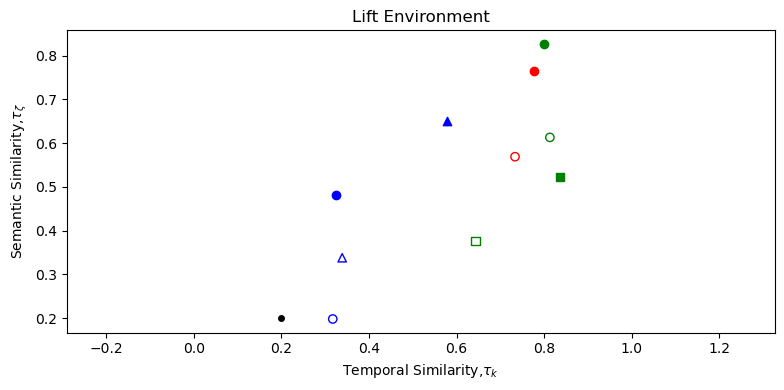

In [99]:
# create unique identifiers

input_mode_mapping = {"textual":"g", 
                      "video":"b", 
                      "textualvideo":"r"}
llm_model_mapping = {"gpt-4-vision-preview":'o', 
                     "gemini-pro":"s", 
                     "video-llava": "^"}
in_context_mapping = {True: "in-context", 
                      False: "NO in-context"}

def get_marker(llm_model: str, input_mode: str) -> str:
    return input_mode_mapping[input_mode]+llm_model_mapping[llm_model]

def plot_similarity2d(temporal_score: np.float64, 
                      semantic_score: np.float64,
                      llm_model: str,
                      ax = None) -> None:
    color = input_mode_mapping[input_mode]
    marker = llm_model_mapping[llm_model]
    ax.scatter(x=temporal_score, 
               y=semantic_score, 
               color=color, 
               marker=marker,
               facecolors='none' if not in_context else None, 
               label=f"{llm_model} | {input_mode} | {in_context_mapping[in_context]}")

env_name = ENVIRONMENT_NAMES[1]
llm_models = ["gpt-4-vision-preview", "gemini-pro", "video-llava"]
input_modes = ["textual", "video", "textualvideo"]
in_contexts = [True, False]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.scatter(x=0.2, y=0.2, color='k', marker='.', label="randomized baseline",linewidths=2)
for llm_model in llm_models:
    for input_mode in input_modes:
        for in_context in in_contexts:
            llm_output_data_path = LLM_OUTPUT_PATH(llm_model=llm_model, 
                                                input_mode=input_mode, 
                                                env_name=env_name, 
                                                in_context=in_context)
            if not os.path.exists(llm_output_data_path+'_results.npz'):
                print(f"{llm_model} {input_mode} DNE")
                continue

            # append to legend
            results = np.load(llm_output_data_path+'_results.npz')
            temporal_score = np.mean(results['temporal'])
            semantic_score = np.mean(results['semantic'])
            # temporal_score = results['temporal']
            # semantic_score = results['semantic']

            plot_similarity2d(temporal_score=temporal_score, 
                                semantic_score=semantic_score, 
                                llm_model=llm_model,
                                ax=ax)
# title_text = f"GPT-4V in {llm_model_mapping["gpt-4-vision-preview"]} and Gemini Pro in {input_mode_mapping["gemini-pro"]} | {env_name} Environment"
ax.set_xlim((0, 1.1))
ax.set_ylim((0, 1))
tau_k = r'$\tau_k$'
tau_zeta = r'$\tau_{\zeta}}$'
ax.set_xlabel("Temporal Similarity,"+ tau_k)
ax.set_ylabel("Semantic Similarity,"+ tau_zeta)
ax.set_title(f"{env_name} Environment")
# ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize='small')
ax.axis('equal')
plt.tight_layout()
plt.show()

### Boxplots of Similarity Metrics

In [ ]:
# Make a dataframe with all the data 

import pandas as pd
LLM_MODELS = ["gpt-4-vision-preview", "gemini-pro", "video-llava"]
INPUT_MODES = ["textual", "video", "textualvideo"]
IN_CONTEXTS = [True, False]
df = pd.DataFrame(columns=["env_name",
                           "llm_model", 
                           "input_mode", 
                           "in_context",
                           "temporal_scores",
                           "semantic_scores"])
for env_name in ENVIRONMENT_NAMES:
    for llm_model in LLM_MODELS:
        for input_mode in INPUT_MODES:
            for in_context in IN_CONTEXTS:
                llm_output_data_path = LLM_OUTPUT_PATH(llm_model=llm_model, 
                                                    input_mode=input_mode, 
                                                    env_name=env_name, 
                                                    in_context=in_context)
                if not os.path.exists(llm_output_data_path+'_results.npz'):
                    print(f"{llm_model} {input_mode} DNE")
                    continue

                # append to legend
                results = np.load(llm_output_data_path+'_results.npz')
                # temporal_scores = results['temporal'].tolist()
                # semantic_scores = results['semantic'].tolist()
                df = df.append({"env_name": env_name,
                                "llm_model": llm_model, 
                                "input_mode": input_mode, 
                                "in_context": in_context, 
                                "temporal_scores": results['temporal'], 
                                "semantic_scores": results['semantic']}, 
                                ignore_index=True)
df["model_input_combo"] = df["llm_model"] + "_" + df["input_mode"]


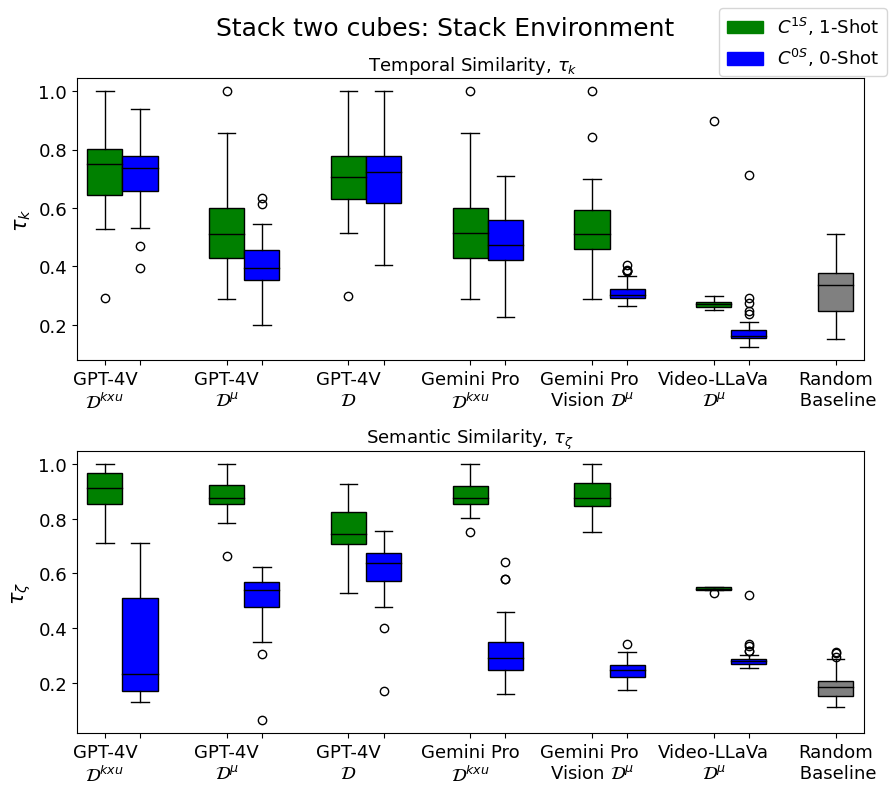

In [99]:
# box plots
LLM_MODELS = ["gpt-4-vision-preview", "gemini-pro", "gemini-pro-vision", "video-llava"]
INPUT_MODES = ["textual", "video", "textualvideo"]
IN_CONTEXTS = [True, False]
env_name = "Stack"

FONTSIZE = 13
textualdata_string = r'$\mathcal{D}^{ kxu}$'
videodata_string = r'$\mathcal{D}^{ \mu}$'
fulldata_string = r'$\mathcal{D}$'
labels = ['GPT-4V\n'+textualdata_string, ' ',
          'GPT-4V\n'+videodata_string, ' ',
          'GPT-4V\n'+fulldata_string, ' ',
          'Gemini Pro\n'+textualdata_string, ' ',
          'Gemini Pro \nVision '+videodata_string, ' ',
          'Video-LLaVa\n'+videodata_string, ' ',
          'Random\n Baseline']

# https://stackoverflow.com/questions/41997493/python-matplotlib-boxplot-color
def box_plot(data, edge_color, fill_color, positions, ax):
    bp = ax.boxplot(data, patch_artist=True, positions=positions)

    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)

    return bp

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(9, 8))
ax1.tick_params(axis='x', labelsize=FONTSIZE)
ax2.tick_params(axis='x', labelsize=FONTSIZE)
ax1.tick_params(axis='y', labelsize=FONTSIZE)
ax2.tick_params(axis='y', labelsize=FONTSIZE)
idx = 0
context_increment = False
for llm_model in LLM_MODELS:
    for input_mode in INPUT_MODES:
        for in_context in IN_CONTEXTS:
            llm_output_data_path = LLM_OUTPUT_PATH(llm_model=llm_model, 
                                                input_mode=input_mode, 
                                                env_name=env_name, 
                                                in_context=in_context)
            context_increment = False
            if not os.path.exists(llm_output_data_path+'_results.npz'):
                # print(f"{llm_model} with {input_mode} DNE", " ")
                continue

            results = np.load(llm_output_data_path+'_results.npz')
            temporal_scores = results['temporal']
            semantic_scores = results['semantic']
            color = 'green' if in_context else 'blue'
            bp1 = box_plot(temporal_scores, 
                          edge_color='black', 
                          fill_color=color, 
                          positions=[idx],
                          ax=ax1)
            bp2 = box_plot(semantic_scores, 
                          edge_color='black', 
                          fill_color=color, 
                          positions=[idx],
                          ax=ax2)
            idx += 0.15
            context_increment = True

        if context_increment:
            idx += 0.22

# plot baselines
baselines = np.load(BASELINES_DATA+f"/{env_name}_baseline.npz")
box_plot(baselines['temporal'],
         edge_color='black',
         fill_color='gray',
         positions=[idx],
         ax=ax1)
box_plot(baselines['semantic'],
         edge_color='black',
         fill_color='gray',
         positions=[idx],
         ax=ax2)

title_maps = {'Door': 'Open a door: Door Environment', 
         'Lift': 'Lift a cube: Lift Environment', 
         'Stack': 'Stack two cubes: Stack Environment', 
         'PickPlace': 'Move a can: PickPlace Environment'}
title = title_maps[env_name]
plt.suptitle(title, fontsize=FONTSIZE+5)
ax1.set_title(f" Temporal Similarity, "+r'$\tau_k$', fontsize=FONTSIZE)
ax2.set_title(f"Semantic Similarity, "+r'$\tau_{\zeta}$', fontsize=FONTSIZE)
ax1.set_ylabel(r'$\tau_k$', fontsize=FONTSIZE+2)
ax2.set_ylabel(r'$\tau_{\zeta}$', fontsize=FONTSIZE+2)
[ax.set_xticklabels(labels) for ax in [ax1, ax2]]
[ax.set_xbound(-0.12, idx+0.12) for ax in [ax1, ax2]]
legend_colors = [mpatches.Patch(color='green', label='In-context'), 
                 mpatches.Patch(color='blue', label='Out-of-context')]
plt.tight_layout()
C1S = r'$C^{1S}$'
C0S = r'$C^{0S}$'
plt.figlegend(legend_colors, [C1S+", 1-Shot", C0S+", 0-Shot"], fontsize=FONTSIZE)
# save plot as svg file
plt.savefig(f"{SAVE_PLOTS_PATH}/{env_name}_boxplot.svg", format="svg")
plt.savefig(f"{SAVE_PLOTS_PATH}/{env_name}_boxplot.png", format="png")

In [11]:
baselines = np.load(BASELINES_DATA+f"/{env_name}_baseline.npz")
baselines['temporal']

array([0.35119915, 0.3953267 , 0.25846836, 0.33856968, 0.22184914,
       0.42424153, 0.32574517, 0.32548684, 0.2240914 , 0.24981463,
       0.40985498, 0.31699523, 0.36106705, 0.26385848, 0.60270779,
       0.25215873, 0.23848978, 0.34425407, 0.26173661, 0.47692832,
       0.42849631, 0.39235675, 0.25150702, 0.23698873, 0.24419289,
       0.26805203, 0.50696078, 0.3044107 , 0.24555646, 0.31452314,
       0.26701648, 0.2246323 , 0.26509865, 0.30573299, 0.23795489,
       0.35284206, 0.31326744, 0.2949923 , 0.379019  , 0.22986623,
       0.26936864, 0.59913862, 0.55279072, 0.37008553, 0.35057449,
       0.24127074, 0.36975175, 0.34020327, 0.32424913, 0.5407197 ])

### Radar Charts

random-baseline textual DNE
random-baseline textual DNE


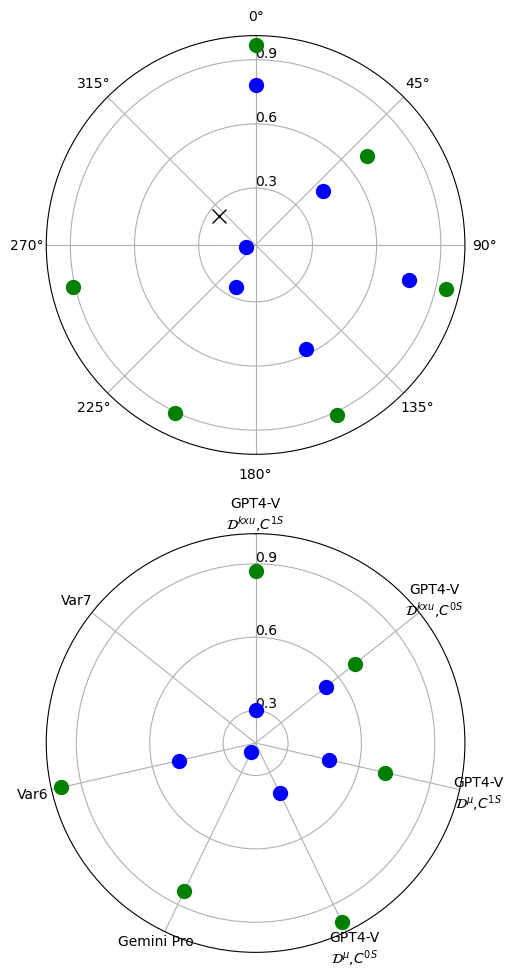

In [74]:
# Make a radar plot, where each plot has the LLMs and random baseline on the circumference, and the mean similarity score as the radius. There will be two shades for the in-context and out-of-context scores

# Create a radar plot
# LLM_MODELS = ["gpt-4-vision-preview", "gemini-pro", "video-llava", "random-baseline"]
LLM_MODELS = {"gpt-4-vision-preview":["textual", "video", "textualvideo"], 
                "gemini-pro":["textual"],
                "gemini-pro-vision":["video"], 
                "video-llava":["video"],
                "random-baseline":["textual"]}
IN_CONTEXT = [True, False]
num_vars = 7

# Split the circle into even parts and save angles so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Draw the outline of our data.
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10), subplot_kw=dict(polar=True))

# Draw one axe per variable and add labels
ax1.set_theta_offset(np.pi / 2)
ax1.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2)
ax2.set_theta_direction(-1)


# Draw ylabels
ax1.set_rlabel_position(0)
ax1.yaxis.set_ticks([0.3, 0.6, 0.9], color="grey", size=1)
ax2.set_rlabel_position(0)
ax2.yaxis.set_ticks([0.3, 0.6, 0.9], color="grey", size=1)
# plt.ylim(0,1)

trajetorydata_string = r'$\mathcal{D}$'
textualdata_string = r'$\mathcal{D}^{kxu}$'
visualdata_sring = r'$\mathcal{D}^{\mu}$'
context_string = r'$C^{1S}$'
no_incontext_string = r'$C^{0S}$'
plt.xticks(angles, ["GPT4-V\n" + textualdata_string +  "," +context_string, 
                    "GPT4-V\n" + textualdata_string +  "," +no_incontext_string, 
                    "GPT4-V\n" + visualdata_sring + "," + context_string, 
                    "GPT4-V\n" + visualdata_sring +  "," +no_incontext_string, 
                    "Gemini Pro\n", 
                    "Var6", "Var7"])

# Plot data
idx = 0
for llm_model in LLM_MODELS:
    for input_mode in LLM_MODELS[llm_model]:
        for in_context in IN_CONTEXT:
            llm_output_data_path = LLM_OUTPUT_PATH(llm_model=llm_model, 
                                                input_mode=input_mode, 
                                                env_name=env_name, 
                                                in_context=in_context)
            if not os.path.exists(llm_output_data_path+'_results.npz'):
                print(f"{llm_model} {input_mode} DNE")
                continue

            results = np.load(llm_output_data_path+'_results.npz')
            temporal_scores = results['temporal'].tolist()
            semantic_scores = results['semantic'].tolist()
            mean_temporal_score = np.mean(results['temporal'])
            mean_semantic_score = np.mean(results['semantic'])

            marker = 'go' if in_context else 'bo'
            ax1.plot(angles[idx], mean_temporal_score, marker, markersize=10)
            ax1.fill(angles[idx], mean_temporal_score, alpha=0.1)
            ax2.plot(angles[idx], mean_semantic_score, marker, markersize=10)
            ax2.fill(angles[idx], mean_semantic_score, alpha=0.1)

        idx += 1

ax1.plot(angles[-1], 0.25, 'kx', markersize=10) # plot baseline
# plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
fig.subplots_adjust(hspace=2)
plt.tight_layout()
plt.show()


### Make histogram of similarity metrics

FileNotFoundError: [Errno 2] No such file or directory: '/Users/jonathansalfity/Documents/dev/task_decomposition/task_decomposition/data/video-llava_outputs/video/PickPlace_results.npz'

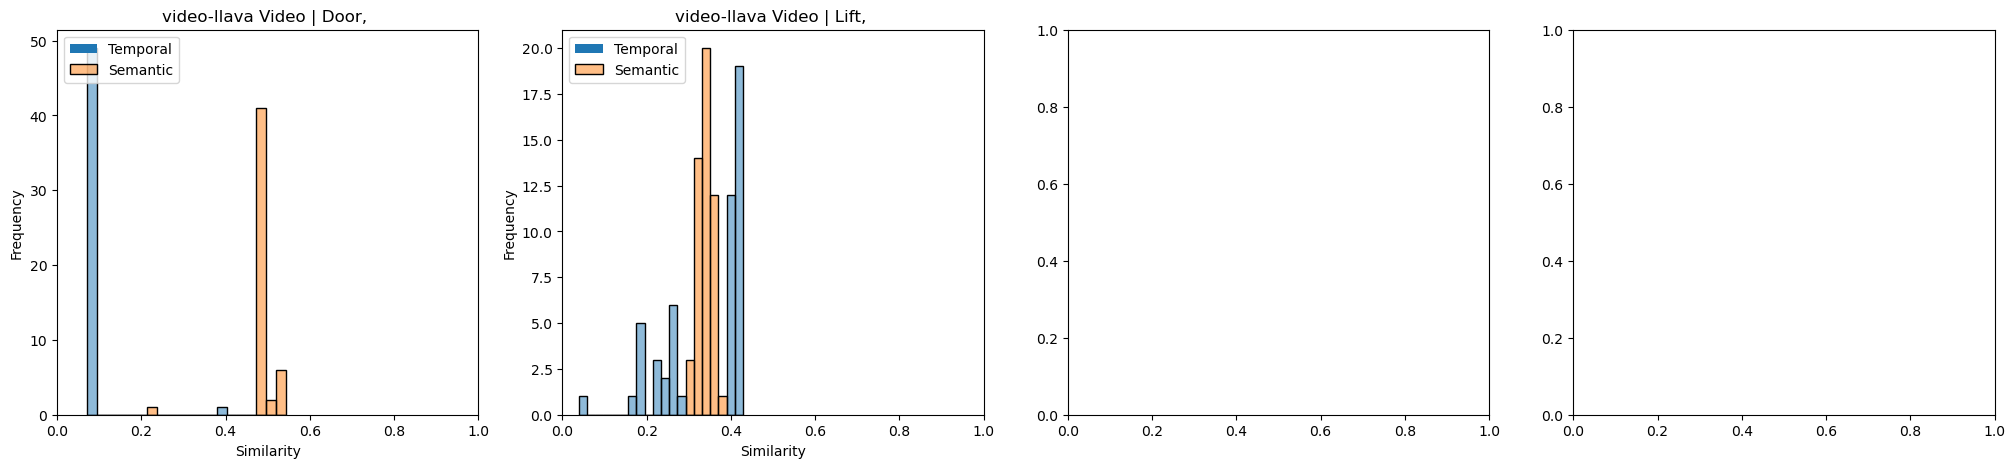

In [46]:
# sns.histplot(data=[temporal, semantic, total], legend=True, kde=True, bins=25)
# env_name = "Door"
# query_type = "video"
# npresultspath = GPT_OUTPUT_PATH+f"/{query_type}/{env_name}" 
# similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
N_BINS = 20
def make_histogram_grid(env_names: list, input_modes: list):
    """
    Create a grid of histograms for the similarity scores between groundtruth and gpt output files.
    Each histogram will show the distribution of the similarity scores for a given environment and query type.
    """
    n_rows = len(input_modes)
    n_cols = len(env_names)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 5*n_rows))
    for i, env_name in enumerate(env_names):
        for j, input_mode in enumerate(input_modes):
            npresultspath = LLM_OUTPUT_PATH(llm_model, input_mode, env_name)
            similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
            temporal = similarity['temporal']
            semantic = similarity['semantic']
            ax = axs[j, i] if n_rows > 1 else axs[i]
            sns.histplot(data=[temporal, semantic], legend=True, bins=N_BINS, ax=ax)
            ax.legend(["Temporal", "Semantic"], loc='upper left')
            ax.set_xlabel('Similarity')
            ax.set_ylabel('Frequency')
            ax.set_xlim(0, 1)
            input_mode = "Text and Video" if input_mode=="textvideo" else input_mode.capitalize()
            ax.set_title(f"{llm_model} {input_mode} | {env_name}, ")

llm_model = "video-llava"
envs = ENVIRONMENT_NAMES
input_modes = ["video"]
make_histogram_grid(envs, input_modes)


### Make LaTex row (LLM_NAME, ENV_NAME, INPUT_MODE, SIMILARITY_METRIC, SIMILARITY_VALUE)

In [146]:
# Make the big table of all the similarity results
llm_model = "gpt-4-vision-preview"
# llm_model = "gemini-pro-vision"
# input_modes = ["textual", "textualvideo" , "video"]
input_modes = ["textualvideo"]
in_context = False
env_names =  ENVIRONMENT_NAMES
print(f"llm_model: {llm_model}, in_context: {in_context}: input_modes: {input_modes}")
print(env_names)
for input_mode in input_modes:
    print(f"{input_mode}: &", end="")
    for env_name in env_names:
        npresultspath =  LLM_OUTPUT_PATH(llm_model=llm_model, 
                                         input_mode=input_mode, 
                                         env_name=env_name,
                                         in_context=in_context)
        similarity = np.load(f"{npresultspath}_results.npz", allow_pickle=True)
        total_mean, total_std = np.mean(similarity['total']), np.std(similarity['total'])
        temporal_mean, temporal_std = np.mean(similarity['temporal']), np.std(similarity['temporal'])
        semantic_mean, semantic_std = np.mean(similarity['semantic']), np.std(similarity['semantic'])
        print(f'${temporal_mean:.2f} \pm {temporal_std:.2f}$ &', end="")
        print(f'${semantic_mean:.2f} \pm {semantic_std:.2f}$ &', end="")

    print('')
    print("______________________________________________________________________")

# Convert to latex:


llm_model: gpt-4-vision-preview, in_context: False: input_modes: ['textualvideo']
['Door', 'Lift', 'PickPlace', 'Stack']
textualvideo: &$0.77 \pm 0.13$ &$0.48 \pm 0.16$ &$0.73 \pm 0.12$ &$0.57 \pm 0.15$ &$0.57 \pm 0.19$ &$0.39 \pm 0.09$ &$0.71 \pm 0.13$ &$0.62 \pm 0.10$ &
______________________________________________________________________


### Compute Random Baselines for Each Environment

In [3]:
print(ENVIRONMENT_NAMES)

SAVE = True
for env_name in ENVIRONMENT_NAMES:
    gt_files = _get_filepaths(env_name=env_name, 
                            llm_model=None, 
                            input_mode=None, 
                            in_context=None,
                            kind="groundtruth")
    # print(f"Env: {env_name}")
    n_runs = len(gt_files)
    output = {"temporal": np.full(n_runs, np.nan), 
              "semantic": np.full(n_runs, np.nan), 
              "total": np.full(n_runs, np.nan)}
    for idx, gt_file in enumerate(gt_files):
        gt_subtask_decomposition = extract_subtask_from_groundtruth_file(gt_file)
        N = gt_subtask_decomposition[-1][END_STEP_IDX]
        random_subtask_decomposition = get_random_subtask_decomposition(N)
        similarity = get_subtask_similarity(gt_subtask_decomposition, 
                                            random_subtask_decomposition)
        temporal = similarity['temporal']
        semantic = similarity['semantic']
        total = similarity['total']
        output['temporal'][idx] = temporal
        output['semantic'][idx] = semantic
        output['total'][idx] = total
        # print(f" Temporal: {temporal:.2f}, Semantic: {semantic:.2f}")

    # save each output
    if SAVE:
        np.savez(BASELINES_DATA+f"/{env_name}_baseline.npz", **output)
    temporal_mean, temporal_std = np.mean(output['temporal']), np.std(output['temporal'])
    semantic_mean, semantic_std = np.mean(output['semantic']), np.std(output['semantic'])

    print(f'${temporal_mean:.2f} \pm {temporal_std:.2f}$ &', end="")
    print(f'${semantic_mean:.2f} \pm {semantic_std:.2f}$ &', end="")


['Door', 'Lift', 'PickPlace', 'Stack']
$0.33 \pm 0.10$ &$0.23 \pm 0.10$ &$0.42 \pm 0.12$ &$0.23 \pm 0.04$ &$0.35 \pm 0.12$ &$0.21 \pm 0.05$ &$0.32 \pm 0.09$ &$0.19 \pm 0.05$ &